In [1]:
import calendar
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 500)
pd.options.display.max_rows = 1000

import geopandas as gpd
from shapely.geometry import Point, Polygon
import calendar

In [2]:
# read and plot station 

stations = pd.read_csv('../../data/STATION.csv')


In [77]:
# input dir
input_dir = '../../data/yearly_climate_by_station/1'

# read all files into one df

import os

files = os.listdir(input_dir)
df = pd.DataFrame()
for file in files:
	df = pd.concat([df, pd.read_csv(os.path.join(input_dir, file))])

# df.head()

# drop column: From date, To date, ESMI_ID

df.drop(['From date', 'To date', 'ESMI_ID'], axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52584 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       52584 non-null  int64  
 1   Location name    52584 non-null  object 
 2   District         52584 non-null  object 
 3   State            52584 non-null  object 
 4   Category         52584 non-null  object 
 5   Connection Type  52584 non-null  object 
 6   Lat              52584 non-null  float64
 7   Lon              52584 non-null  float64
 8   t2m              52584 non-null  float64
 9   u10              52584 non-null  float64
 10  v10              52584 non-null  float64
 11  tp               52584 non-null  float64
 12  date             52584 non-null  int64  
 13  time             52584 non-null  int64  
dtypes: float64(6), int64(3), object(5)
memory usage: 6.0+ MB


In [80]:
# Convert 'date' to a string and 'time' from int64 to a string, ensuring proper formatting
df['date'] = df['date'].astype(str)
# Convert 'time' to string and pad with zeros if necessary
df['time'] = df['time'].astype(str).apply(lambda x: x.zfill(4))

# Combine 'date' and 'time' columns and convert to datetime
df['datetime'] = pd.to_datetime(df['date'] + df['time'], format='%Y%m%d%H%M')

# Display the result
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52584 entries, 0 to 8759
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Unnamed: 0       52584 non-null  int64         
 1   Location name    52584 non-null  object        
 2   District         52584 non-null  object        
 3   State            52584 non-null  object        
 4   Category         52584 non-null  object        
 5   Connection Type  52584 non-null  object        
 6   Lat              52584 non-null  float64       
 7   Lon              52584 non-null  float64       
 8   t2m              52584 non-null  float64       
 9   u10              52584 non-null  float64       
 10  v10              52584 non-null  float64       
 11  tp               52584 non-null  float64       
 12  date             52584 non-null  object        
 13  time             52584 non-null  object        
 14  datetime         52584 non-null  dateti

In [81]:
df.set_index('datetime', inplace=True)

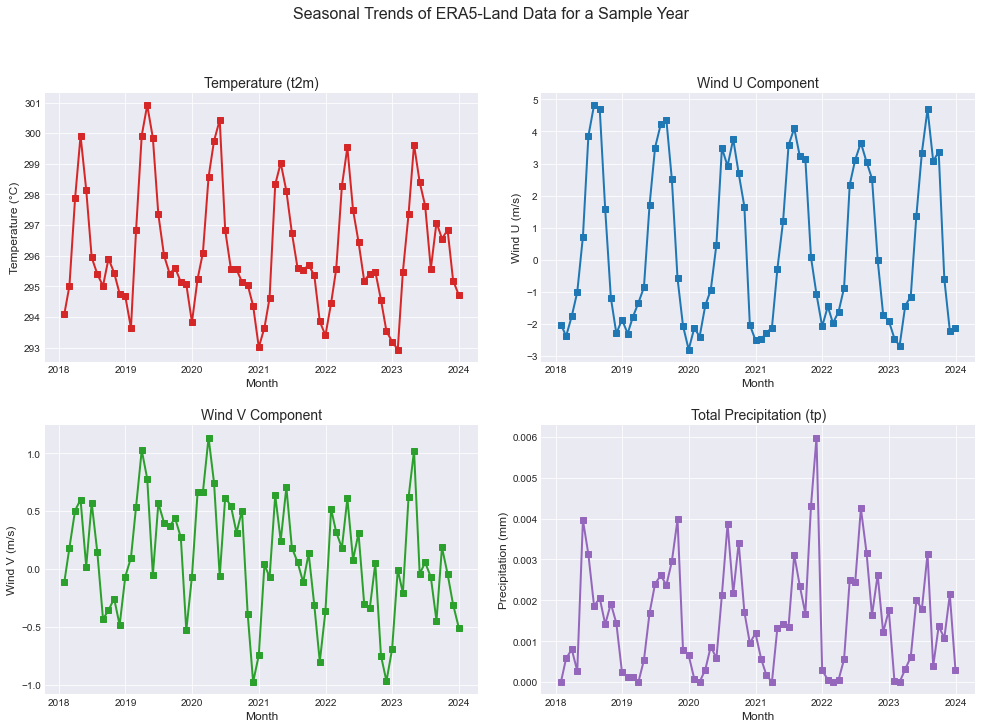

In [82]:
# Resample data to monthly means to observe seasonal trends
df_monthly = df.resample('M').mean()

# Set up plot aesthetics
plt.style.use('seaborn-darkgrid')  # Use a clean grid style

# Create figure and axes for subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Seasonal Trends of ERA5-Land Data for a Sample Year',
             fontsize=16, y=1.02)

# Temperature (t2m)
axes[0, 0].plot(df_monthly.index, df_monthly['t2m'], marker='s',
                color='tab:red', linewidth=2, markersize=6)
axes[0, 0].set_title('Temperature (t2m)', fontsize=14)
axes[0, 0].set_ylabel('Temperature (°C)', fontsize=12)
axes[0, 0].grid(True)

# Wind component (u10)
axes[0, 1].plot(df_monthly.index, df_monthly['u10'],
                marker='s', color='tab:blue', linewidth=2, markersize=6)
axes[0, 1].set_title('Wind U Component', fontsize=14)
axes[0, 1].set_ylabel('Wind U (m/s)', fontsize=12)
axes[0, 1].grid(True)

# Wind component (v10)
axes[1, 0].plot(df_monthly.index, df_monthly['v10'],
                marker='s', color='tab:green', linewidth=2, markersize=6)
axes[1, 0].set_title('Wind V Component', fontsize=14)
axes[1, 0].set_ylabel('Wind V (m/s)', fontsize=12)
axes[1, 0].grid(True)

# Total Precipitation (tp)
axes[1, 1].plot(df_monthly.index, df_monthly['tp'], marker='s',
                color='tab:purple', linewidth=2, markersize=6)
axes[1, 1].set_title('Total Precipitation (tp)', fontsize=14)
axes[1, 1].set_ylabel('Precipitation (mm)', fontsize=12)
axes[1, 1].grid(True)

# Add a shared x-label
for ax in axes.flat:
    ax.set_xlabel('Month', fontsize=12)

# Auto-adjust layout
plt.tight_layout(pad=2)

# Show plot
plt.show()

Note: Plotting the 1,424 ids may result in messy charts and never-ending facetgrids that take for ever to load. Best to sample a few ids used consistently throughout the notebook, and run the analyses for a few samples before making final conclusions.

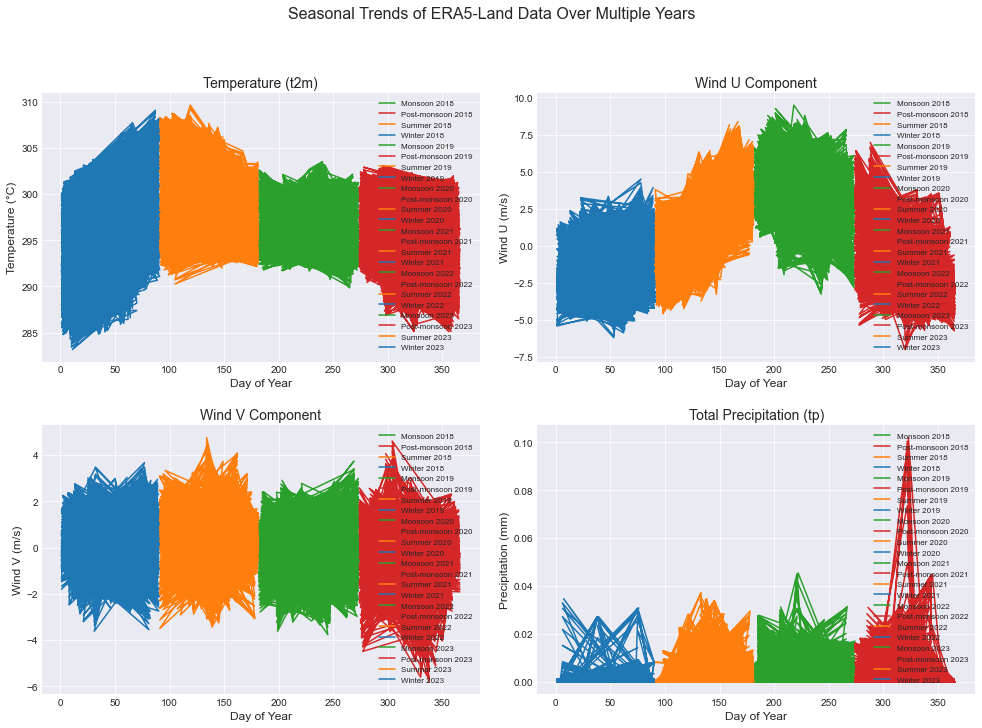

<Figure size 432x288 with 0 Axes>

In [87]:


# Extract the year and month for season identification
df['year'] = df.index.year
df['month'] = df.index.month

# Define seasons based on month


def get_season(month):
    # spring 3-5, summer 6-8, monsoon 9-11, winter 12-2
    if month in [1, 2, 3]:
        return 'Winter'
    elif month in [4, 5, 6]:
        return 'Summer'
    elif month in [7, 8, 9]:
        return 'Monsoon'
    else:
        return 'Post-monsoon'


df['season'] = df['month'].apply(get_season)

# Set up plot aesthetics
plt.style.use('seaborn-darkgrid')  # Use a clean grid style

# Create figure and axes for subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(
    'Seasonal Trends of ERA5-Land Data Over Multiple Years', fontsize=16, y=1.02)

# Define colors for each season
season_colors = {'Winter': 'tab:blue', 'Summer': 'tab:orange',
                 'Monsoon': 'tab:green', 'Post-monsoon': 'tab:red'}

# Function to plot data for each variable by season


def plot_seasonal_trend(ax, variable, title, ylabel):
    for year, group in df.groupby('year'):
        for season, season_group in group.groupby('season'):
            ax.plot(season_group.index.dayofyear, season_group[variable],
                    color=season_colors[season], label=f'{season} {year}' if year == group['year'].min() else "")

    ax.set_title(title, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True)


# Plot seasonal trends for each variable
plot_seasonal_trend(axes[0, 0], 't2m', 'Temperature (t2m)', 'Temperature (°C)')
plot_seasonal_trend(axes[0, 1], 'u10', 'Wind U Component', 'Wind U (m/s)')
plot_seasonal_trend(axes[1, 0], 'v10', 'Wind V Component', 'Wind V (m/s)')
plot_seasonal_trend(
    axes[1, 1], 'tp', 'Total Precipitation (tp)', 'Precipitation (mm)')

# Add a shared x-label (Day of Year)
for ax in axes.flat:
    ax.set_xlabel('Day of Year', fontsize=12)

# Auto-adjust layout
plt.tight_layout(pad=2)

# Show plot
plt.show()

# save plot

plt.savefig('../../data/seasonal_trends_multiple_years_stack.png', dpi=300)

In [68]:

plt.savefig('../../data/seasonal_trends_multiple_years.png', dpi=300)

<Figure size 432x288 with 0 Axes>

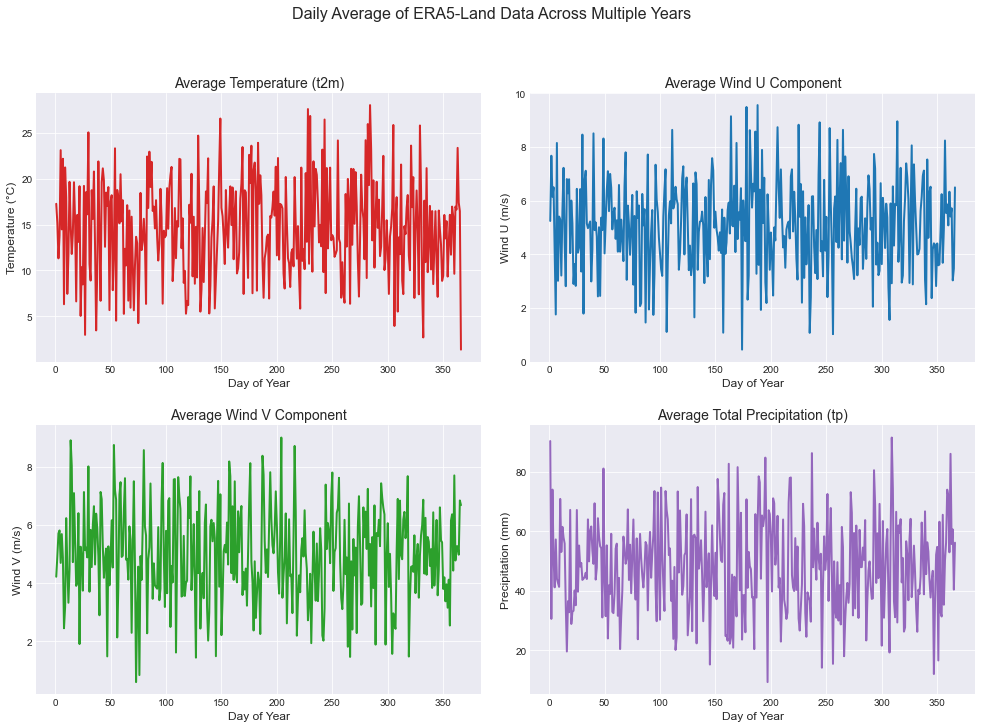

In [71]:

# fix u10 v10 use absolute value
# Extract the day of year for each row
df['day_of_year'] = df.index.dayofyear

# calculate the absolute wind speed for mean

df['wind_speed'] = np.sqrt(df['u10']**2 + df['v10']**2)


# use the absolute wind_u and wind_v for mean

df['u10_absolute'] = np.abs(df['u10'])
df['v10_absolute'] = np.abs(df['v10'])


df_daily_avg = df.groupby('day_of_year').mean()

# Set up plot aesthetics
plt.style.use('seaborn-darkgrid')  # Use a clean grid style

# Create figure and axes for subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(
    'Daily Average of ERA5-Land Data Across Multiple Years', fontsize=16, y=1.02)

# Plot average t2m
axes[0, 0].plot(df_daily_avg.index, df_daily_avg['t2m'],
                color='tab:red', linewidth=2)
axes[0, 0].set_title('Average Temperature (t2m)', fontsize=14)
axes[0, 0].set_ylabel('Temperature (°C)', fontsize=12)
axes[0, 0].grid(True)

# Plot average u10
axes[0, 1].plot(df_daily_avg.index, df_daily_avg['u10'],
                color='tab:blue', linewidth=2)
axes[0, 1].set_title('Average Wind U Component', fontsize=14)
axes[0, 1].set_ylabel('Wind U (m/s)', fontsize=12)
axes[0, 1].grid(True)

# Plot average v10
axes[1, 0].plot(df_daily_avg.index, df_daily_avg['v10'],
                color='tab:green', linewidth=2)
axes[1, 0].set_title('Average Wind V Component', fontsize=14)
axes[1, 0].set_ylabel('Wind V (m/s)', fontsize=12)
axes[1, 0].grid(True)

# Plot average total precipitation (tp)
axes[1, 1].plot(df_daily_avg.index, df_daily_avg['tp'],
                color='tab:purple', linewidth=2)
axes[1, 1].set_title('Average Total Precipitation (tp)', fontsize=14)
axes[1, 1].set_ylabel('Precipitation (mm)', fontsize=12)
axes[1, 1].grid(True)

# Add a shared x-label
for ax in axes.flat:
    ax.set_xlabel('Day of Year', fontsize=12)

# Auto-adjust layout
plt.tight_layout(pad=2)

# Show plot
plt.show()

plt.savefig('../../data/daily_avg_multiple_years.png', dpi=300)

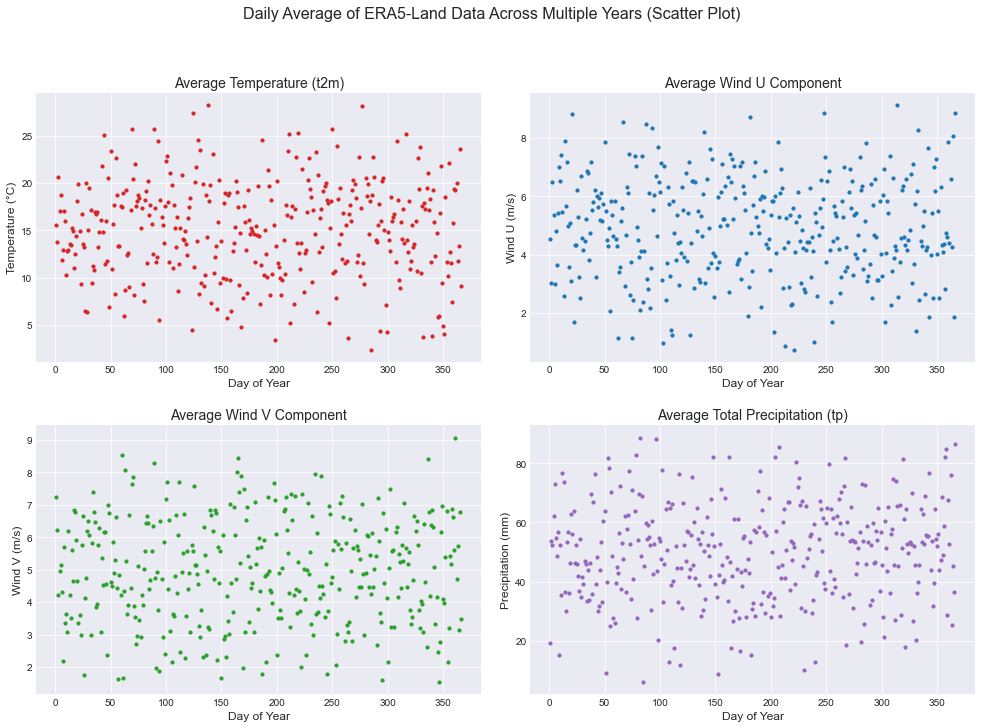

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample DataFrame (replace with your actual data)
data = {
    # 3 years of daily data
    'datetime': pd.date_range(start='2020-01-01', periods=1095, freq='D'),
    't2m': np.random.rand(1095) * 30,  # Simulated temperature values
    'wind_u': np.random.rand(1095) * 10,  # Simulated wind_u values
    'wind_v': np.random.rand(1095) * 10,  # Simulated wind_v values
    'tp': np.random.rand(1095) * 100,  # Simulated precipitation values
}
df = pd.DataFrame(data)

# Set the datetime column as the index
df.set_index('datetime', inplace=True)

# Extract the day of year for each row
df['day_of_year'] = df.index.dayofyear

# Group by day_of_year and calculate the average for each variable across all years
df_daily_avg = df.groupby('day_of_year').mean()

# Set up plot aesthetics
plt.style.use('seaborn-darkgrid')  # Use a clean grid style

# Create figure and axes for subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(
    'Daily Average of ERA5-Land Data Across Multiple Years (Scatter Plot)', fontsize=16, y=1.02)

# Scatter plot for average t2m
axes[0, 0].scatter(df_daily_avg.index, df_daily_avg['t2m'],
                   color='tab:red', s=10)
axes[0, 0].set_title('Average Temperature (t2m)', fontsize=14)
axes[0, 0].set_ylabel('Temperature (°C)', fontsize=12)
axes[0, 0].grid(True)

# Scatter plot for average wind_u
axes[0, 1].scatter(df_daily_avg.index,
                   df_daily_avg['wind_u'], color='tab:blue', s=10)
axes[0, 1].set_title('Average Wind U Component', fontsize=14)
axes[0, 1].set_ylabel('Wind U (m/s)', fontsize=12)
axes[0, 1].grid(True)

# Scatter plot for average wind_v
axes[1, 0].scatter(df_daily_avg.index, df_daily_avg['wind_v'],
                   color='tab:green', s=10)
axes[1, 0].set_title('Average Wind V Component', fontsize=14)
axes[1, 0].set_ylabel('Wind V (m/s)', fontsize=12)
axes[1, 0].grid(True)

# Scatter plot for average total precipitation (tp)
axes[1, 1].scatter(df_daily_avg.index, df_daily_avg['tp'],
                   color='tab:purple', s=10)
axes[1, 1].set_title('Average Total Precipitation (tp)', fontsize=14)
axes[1, 1].set_ylabel('Precipitation (mm)', fontsize=12)
axes[1, 1].grid(True)

# Add a shared x-label (Day of Year)
for ax in axes.flat:
    ax.set_xlabel('Day of Year', fontsize=12)

# Auto-adjust layout
plt.tight_layout(pad=2)

# Show plot
plt.show()

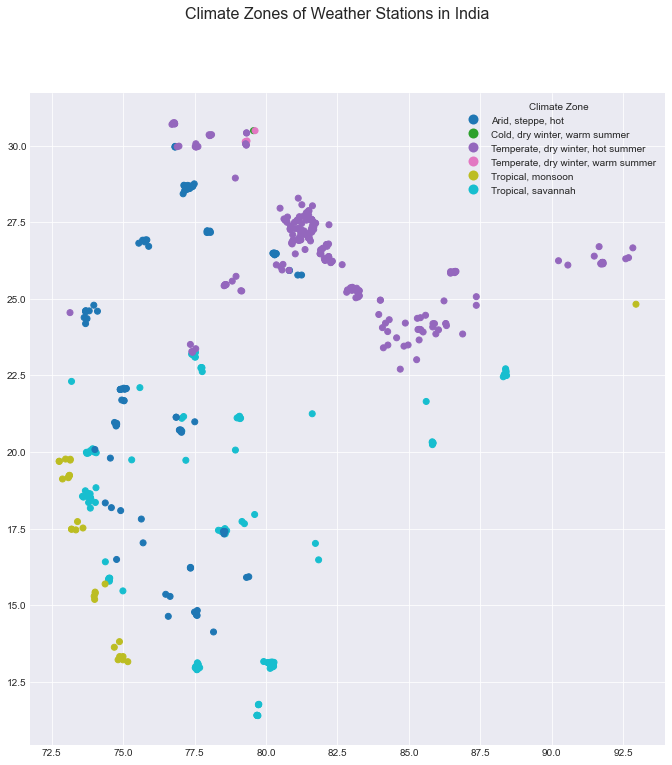

In [47]:
stations_gdf = gpd.read_file('../../data/STATION.geojson')

plt.style.use('seaborn-darkgrid')  

fig, ax = plt.subplots(figsize=(12, 12))
fig.suptitle('Climate Zones of Weather Stations in India', fontsize=16)


stations_gdf.plot(column='climate_zone_name', categorical=True, legend=True,
				  legend_kwds={'title': 'Climate Zone'}, ax=ax)

plt.show()


# visualize annual temperature change

# choropleth map

In [45]:

india_gdf = gpd.read_file('../../data/helper/Indian_Climate_Zone(dissolved).geojson')

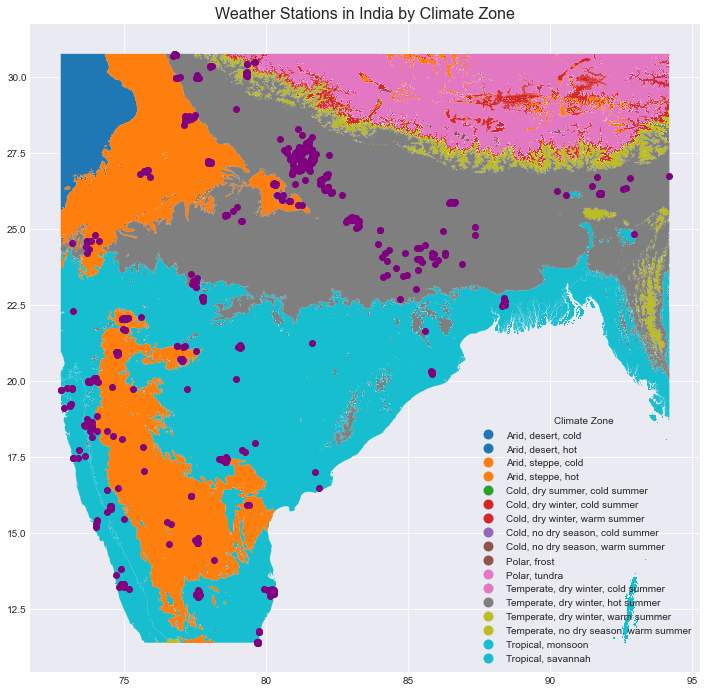

In [48]:
plt.style.use('seaborn-darkgrid')  
fig, ax = plt.subplots(figsize=(12, 12))
india_gdf.plot(column='name_climate', categorical=True, legend=True,
			   
			   legend_kwds={'title': 'Climate Zone'}, ax=ax)
stations_gdf.plot(ax=ax, color='purple', label='Weather Stations')
ax.set_title('Weather Stations in India by Climate Zone', fontsize=16)
# plt.show()

# save the plot
plt.savefig('../../data/weather_stations_climate_zones.png', dpi=600)

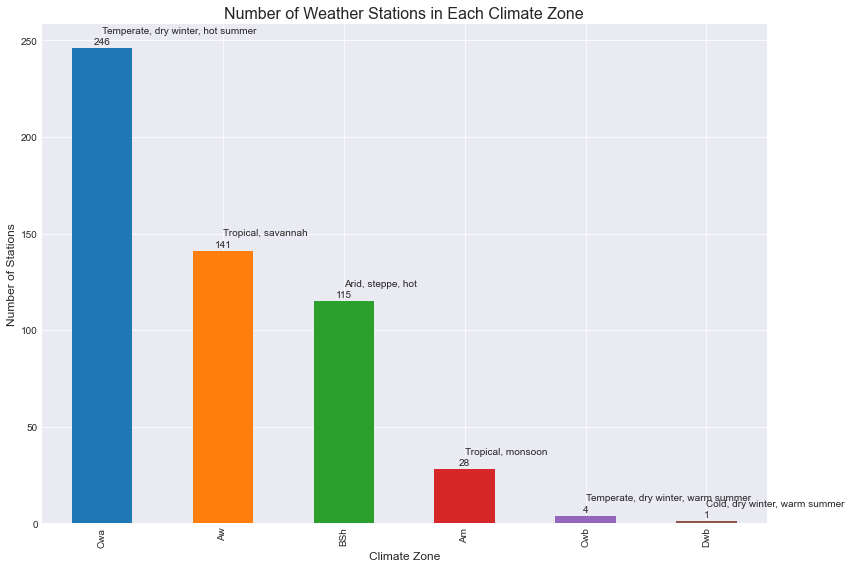

In [55]:

plt.style.use('seaborn-darkgrid') 

fig, ax = plt.subplots(figsize=(12, 8))

stations_gdf['climate_zone_code'].value_counts().plot(
	kind='bar', ax=ax)

# use different color for each climate zone

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

for i, p in enumerate(ax.patches):
	p.set_facecolor(colors[i])

ax.set_title('Number of Weather Stations in Each Climate Zone', fontsize=16)
ax.set_ylabel('Number of Stations', fontsize=12)
ax.set_xlabel('Climate Zone', fontsize=12)

# add text to side, showing the climate zone name

for i, p in enumerate(ax.patches):
	ax.text(i, p.get_height() + 8, stations_gdf['climate_zone_name'].value_counts().index[i],ha='left')


# add text label to each bar, showing the count

for i, p in enumerate(ax.patches):
	ax.text(i, p.get_height() + 2, str(p.get_height()), ha='center')

plt.tight_layout()


plt.savefig('../../data/weather_stations_climate_zones_bar.png', dpi=600)



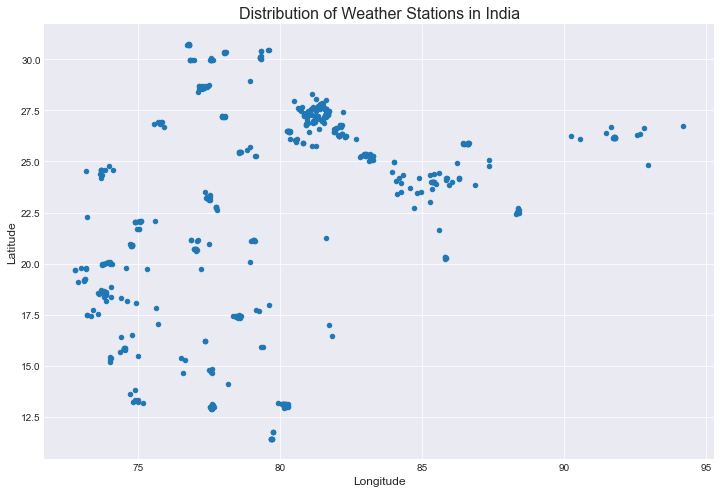

In [56]:
# analyze the lat and lon distribution of the stations

plt.style.use('seaborn-darkgrid')

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(stations_gdf['Lon'], stations_gdf['Lat'], color='tab:blue', s=20)
ax.set_title('Distribution of Weather Stations in India', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)

ax.set_ylabel('Latitude', fontsize=12)

plt.show()


/Users/rainylty/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


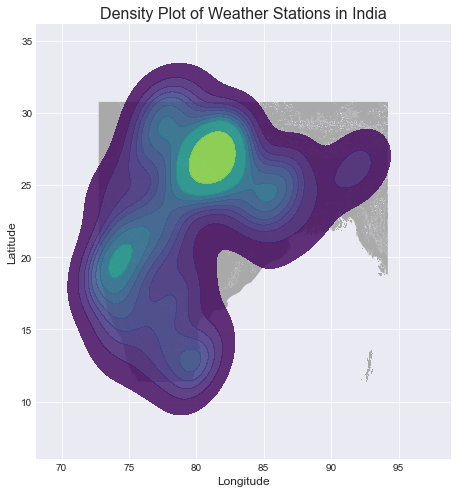

In [67]:

# show density plot

plt.style.use('seaborn-darkgrid')


fig, ax = plt.subplots(figsize=(12, 8))

india_gdf.plot(ax=ax, color='darkgrey', linewidth=1)


sns.kdeplot(stations_gdf['Lon'], stations_gdf['Lat'], cmap='viridis', shade=True, alpha=0.85, ax=ax)



ax.set_title('Density Plot of Weather Stations in India', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)


# plt.show()
# save the plot

plt.savefig('../../data/weather_stations_density.png', dpi=600)

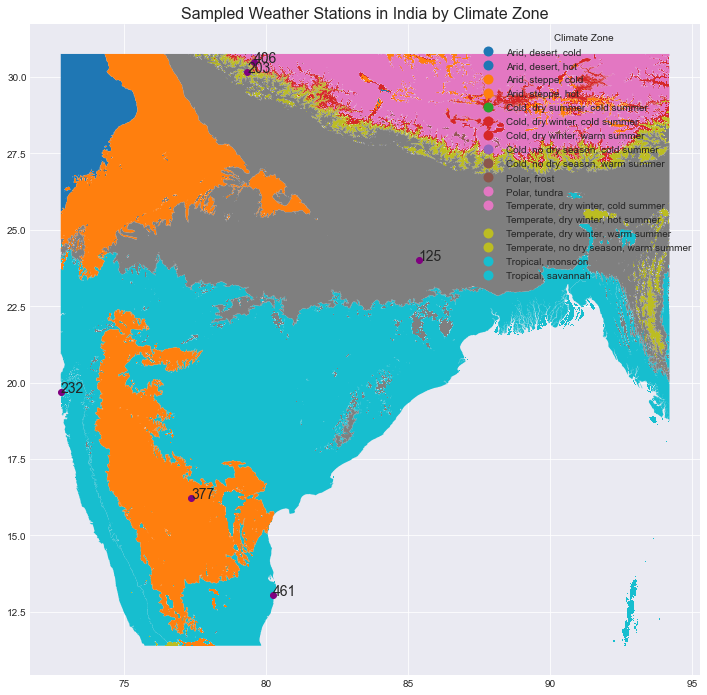

In [141]:
# set seed for random sampling
# np.random.seed(1001)


plt.style.use('seaborn-darkgrid') 

fig, ax = plt.subplots(figsize=(12, 12))
\
india_gdf.plot(column='name_climate', categorical=True, legend=True,
			   legend_kwds={'title': 'Climate Zone'}, ax=ax)

sample_stations = stations_gdf.groupby('climate_zone_name').sample(1)

# add the sampled stations to the plot

for i, station in sample_stations.iterrows():
	ax.text(station['Lon'], station['Lat'], station['station_id'], fontsize=14)

sample_stations.plot(ax=ax, color='purple', label='Weather Stations')

ax.set_title('Sampled Weather Stations in India by Climate Zone', fontsize=16)


# save the plot

plt.savefig('../../data/sample_weather_stations_climate_zones.png', dpi=400)


In [78]:

sample_stations

station_id      Location name  ESMI_ID        Category Connection Type  \
243         471              Thana      NaN  Gram Panchayat     Agriculture   
256         406  Saliyana Gairsain      NaN  Gram Panchayat        Domestic   
474         455         Sulindabad      NaN  Gram Panchayat        Domestic   
285         203          Jhinjhoni      NaN  Gram Panchayat        Domestic   
269         232            Karsood      NaN  Gram Panchayat        Domestic   
49          198          Jayanagar      NaN   State Capital        Domestic   

           Lat        Lon  climate_zone_DN  \
243  24.606380  73.699375              6.0   
256  30.484334  79.561868             22.0   
474  25.851495  86.601888             11.0   
285  30.149446  79.335876             12.0   
269  19.693347  72.769187              2.0   
49   12.935778  77.592047              3.0   

                      climate_zone_name climate_zone_code  \
243                   Arid, steppe, hot               BSh   
256       Cold, dry winter, warm summer               Dwb   
474   Temperate, dry winter, hot summer               Cwa   
285  Temperate, dry winter, warm summer               Cwb   
269                   Tropical, monsoon                Am   
49                   Tropical, savannah                Aw   

                      geometry  
243  POINT (73.69937 24.60638)  
256  POINT (79.56187 30.48433)  
474  POINT (86.60189 25.85150)  
285  POINT (79.33588 30.14945)  
269  POINT (72.76919 19.69335)  
49   POINT (77.59205 12.93578)

In [37]:
# show sampleed station id, name, and climate zone

sample_stations

station_id      Location name  ESMI_ID               Category  \
246         486              Uppal      NaN          State Capital   
256         406  Saliyana Gairsain      NaN         Gram Panchayat   
470         445      Sikandarabad       NaN         Gram Panchayat   
286         208      Jungle Chatti      NaN  District Headquarters   
273         265            Lokgram      NaN   Other Municipal Area   
55          217   Kalpataru Nagar       NaN  District Headquarters   

    Connection Type        Lat        Lon  climate_zone_DN  \
246        Domestic  17.404338  78.563536              6.0   
256        Domestic  30.484334  79.561868             22.0   
470        Domestic  27.954139  80.491162             11.0   
286        Domestic  30.116459  79.277215             12.0   
273        Domestic  19.228273  73.125389              2.0   
55         Domestic  19.977226  73.798872              3.0   

                      climate_zone_name climate_zone_code  \
246                   Arid, steppe, hot               BSh   
256       Cold, dry winter, warm summer               Dwb   
470   Temperate, dry winter, hot summer               Cwa   
286  Temperate, dry winter, warm summer               Cwb   
273                   Tropical, monsoon                Am   
55                   Tropical, savannah                Aw   

                      geometry  
246  POINT (78.56354 17.40434)  
256  POINT (79.56187 30.48433)  
470  POINT (80.49116 27.95414)  
286  POINT (79.27722 30.11646)  
273  POINT (73.12539 19.22827)  
55   POINT (73.79887 19.97723)

## Seasonal Trend in Each Sample Station

with descending order of climate zones

1. station 445 - Temperate, dry winter, hot summer
2. station 217 - Tropical, savannah	
3. station 486 - Arid, steppe, hot	
4. station 193 - Tropical mansoon
5. station 208 - Temperate, dry winter, warm summer
5. station 265 - Tropical, monsoon	

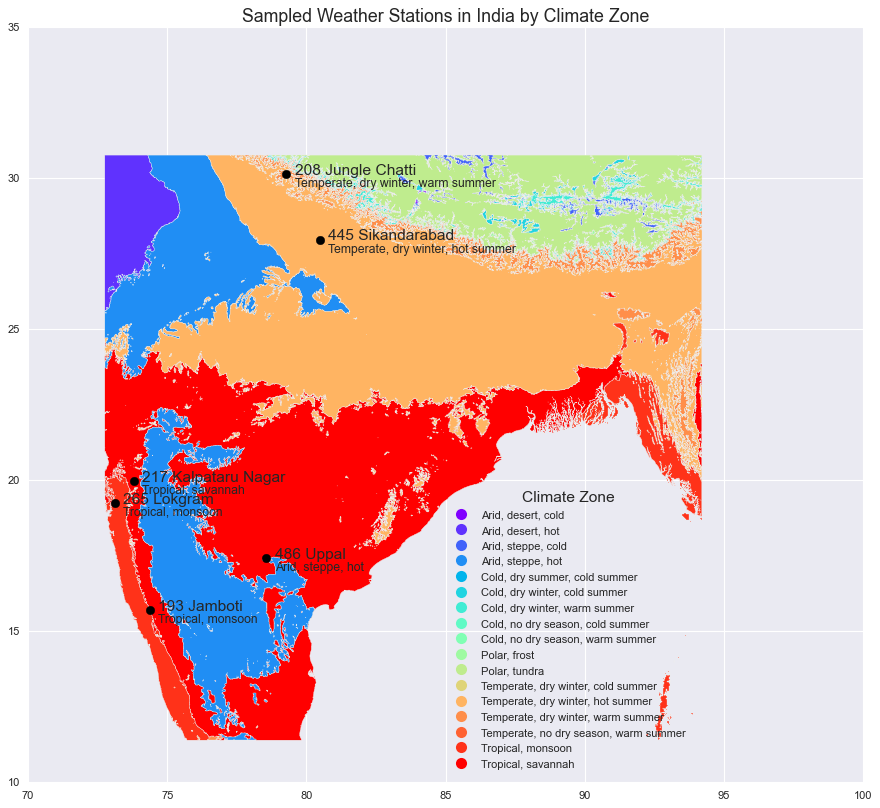

In [208]:
# plot the following stations on the map: 445, 217, 486, 193, 208, 265, with station id and name

plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(12, 12))


num_zones = india_gdf['name_climate'].nunique()
colors = plt.get_cmap('rainbow', num_zones)

india_gdf.plot(column='name_climate', categorical=True, legend=True,
               cmap=colors, legend_kwds={'title': 'Climate Zone'}, ax=ax)

# do not show edges of the climate zones
india_gdf.boundary.plot(ax=ax, linewidth=0)



ax.get_legend().set_bbox_to_anchor((0.8, 0.4))
# make legend fond smaller
ax.get_legend().set_title('Climate Zone')

for t in ax.get_legend().texts:
	t.set_fontsize(10)


sample_stations = stations_gdf[stations_gdf['station_id'].isin([445, 217, 486, 193, 208, 265])]


for i, station in sample_stations.iterrows():
	# add white buffer around the text

	ax.text(station['Lon'] + 0.3, station['Lat'],
	        f"{station['station_id']} {station['Location name']}", fontsize=14)
	# add a line to the station, showing the climate zone
	ax.text(station['Lon'] + 0.3, station['Lat'] - 0.4, station['climate_zone_name'], fontsize=11)

sample_stations.plot(ax=ax, color='black', label='Weather Stations', markersize=60)

ax.set_title('Sampled Weather Stations in India by Climate Zone', fontsize=16)


plt.savefig('../../data/sampled_weather_stations_climate_zones.png', dpi=600)

In [21]:

def read_climate_data(input_dir):
	files = os.listdir(input_dir)
	df = pd.DataFrame()
	for file in files:
		df = pd.concat([df, pd.read_csv(os.path.join(input_dir, file))])
				
	df.drop(['From date', 'To date', 'ESMI_ID'], axis=1, inplace=True)
	df['date'] = df['date'].astype(str)
	df['time'] = df['time'].astype(str).apply(lambda x: x.zfill(4))
	df['datetime'] = pd.to_datetime(df['date'] + df['time'], format='%Y%m%d%H%M')
	df.set_index('datetime', inplace=True)

	print('Finished reading data...info below:')
	print(df.info())

	# get the last folder name of input dir

	folder_name = input_dir.split('/')[-1]
	print(df.index)
	return df

In [33]:

def get_season(month):
    # spring 3-5, summer 6-8, monsoon 9-11, winter 12-2
    if month in [1, 2, 3]:
        return 'Winter'
    elif month in [4, 5, 6]:
        return 'Summer'
    elif month in [7, 8, 9]:
        return 'Monsoon'
    else:
        return 'Post-monsoon'

In [165]:

def plot_seasonal_trends(input_dir):
	df = read_climate_data(input_dir)
	folder_name = input_dir.split('/')[-1]

	df['year'] = df.index.year
	df['month'] = df.index.month
	df['season'] = df['month'].apply(get_season)

	plt.style.use('seaborn-darkgrid')  
	# plt.style.use('bmh')

	fig, axes = plt.subplots(2, 2, figsize=(14, 10))
	fig.suptitle(
		'Seasonal Trends of ERA5-Land Data Over Multiple Years', fontsize=16, y=1.02)

	season_colors = {'Winter': 'tab:blue', 'Summer': 'tab:orange',
					 'Monsoon': 'tab:green', 'Post-monsoon': 'tab:red'}

	def plot_seasonal_trend(ax, variable, title, ylabel):
		for year, group in df.groupby('year'):
			for season, season_group in group.groupby('season'):
				ax.plot(season_group.index.dayofyear, season_group[variable],
						color=season_colors[season], label=f'{season} {year}' if year == group['year'].min() else "")

		ax.set_title(title, fontsize=14)
		ax.set_ylabel(ylabel, fontsize=12)
		# ax.legend(loc='upper right', fontsize=8)
		ax.grid(True)

	plot_seasonal_trend(axes[0, 0], 't2m', 'Temperature (t2m)', 'Temperature (°C)')
	plot_seasonal_trend(axes[0, 1], 'u10', 'Wind U Component', 'Wind U (m/s)')
	plot_seasonal_trend(axes[1, 0], 'v10', 'Wind V Component', 'Wind V (m/s)')
	plot_seasonal_trend(
		axes[1, 1], 'tp', 'Total Precipitation (tp)', 'Precipitation (mm)')

	for ax in axes.flat:
		ax.set_xlabel('Day of Year', fontsize=12)

	plt.tight_layout(pad=2)
	# plt.legend().remove()
	fig.suptitle(
		f'Seasonal Trends of ERA5-Land Data Over Multiple Years (station_id :{folder_name})', fontsize=16, y=1.02)
	
	plt.savefig(
		f'../../data/seasonal_trends_multiple_years_{folder_name}.png', dpi=600)

	print('Finished plotting seasonal trends...')
	print(f'../../data/seasonal_trends_multiple_years_{folder_name}.png')

In [ ]:
read_climate_data('../../data/station_climate_by_year/217')

Finished reading data...info below:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 98517 entries, 2023-07-06 04:00:00 to 2013-08-03 16:00:00
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       98517 non-null  int64  
 1   Location name    98517 non-null  object 
 2   District         98517 non-null  object 
 3   State            98517 non-null  object 
 4   Category         98517 non-null  object 
 5   Connection Type  98517 non-null  object 
 6   Lat              98517 non-null  float64
 7   Lon              98517 non-null  float64
 8   t2m              98517 non-null  float64
 9   u10              98517 non-null  float64
 10  v10              98517 non-null  float64
 11  tp               98517 non-null  float64
 12  date             98517 non-null  object 
 13  time             98517 non-null  object 
dtypes: float64(6), int64(1), object(7)
memory usage: 11.3+ MB
None
DatetimeIndex(['

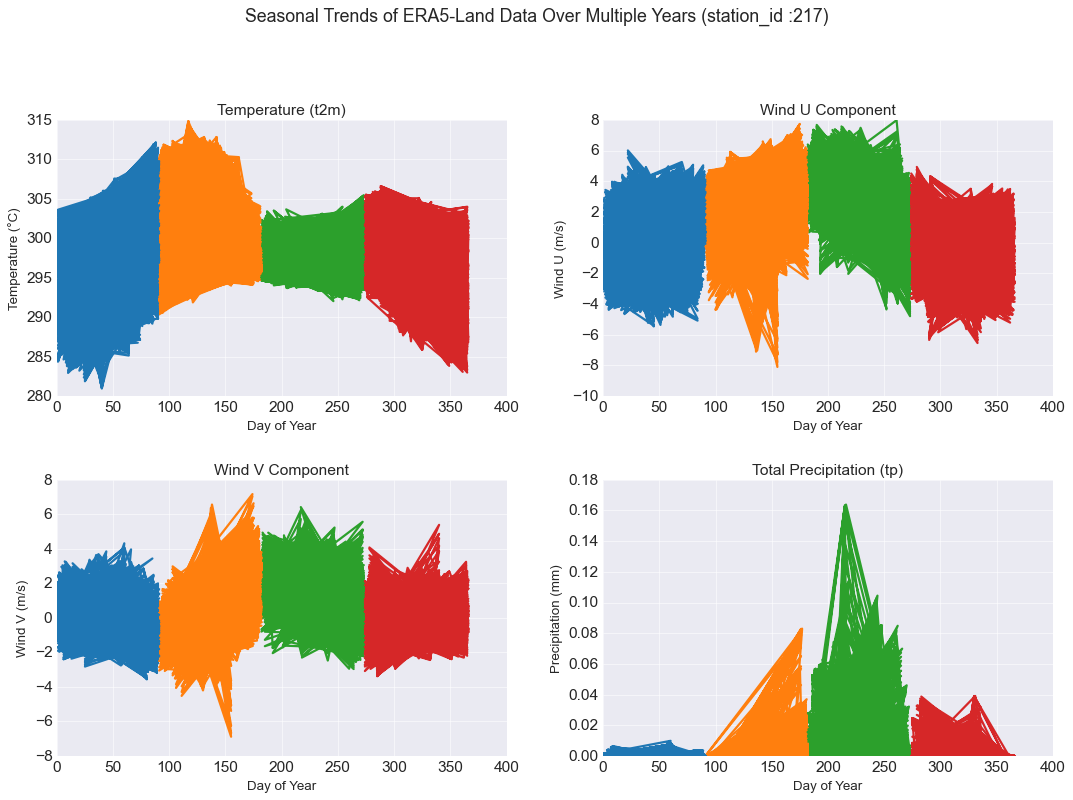

In [166]:
plot_seasonal_trends('../../data/station_climate_by_year/217')

In [ ]:
plot_seasonal_trends('../../data/station_climate_by_year/445')

In [ ]:
plot_seasonal_trends('../../data/station_climate_by_year/486')

In [74]:
# turn to function

def plot_daily_average_in_years(input_dir):

	df = read_climate_data(input_dir)
	folder_name = input_dir.split('/')[-1]

	df['day_of_year'] = df.index.dayofyear
	df['wind_speed'] = np.sqrt(df['u10']**2 + df['v10']**2)

	df['u10_absolute'] = np.abs(df['u10'])
	df['v10_absolute'] = np.abs(df['v10'])

	df_daily_avg = df.groupby('day_of_year').mean()

	plt.style.use('seaborn-darkgrid')  

	fig, axes = plt.subplots(2, 2, figsize=(14, 10))
	fig.suptitle(
		'Daily Average of ERA5-Land Data Across Multiple Years', fontsize=16, y=1.02)

	# Plot average t2m
	axes[0, 0].plot(df_daily_avg.index, df_daily_avg['t2m'],
					color='tab:red', linewidth=2)
	axes[0, 0].set_title('Average Temperature (t2m)', fontsize=14)
	axes[0, 0].set_ylabel('Temperature (°C)', fontsize=12)
	axes[0, 0].grid(True)

	# Plot average u10
	axes[0, 1].plot(df_daily_avg.index, df_daily_avg['u10_absolute'],
					color='tab:blue', linewidth=2)
	axes[0, 1].set_title('Average Wind U Component', fontsize=14)
	axes[0, 1].set_ylabel('Wind U (m/s)', fontsize=12)
	axes[0, 1].grid(True)

	# Plot average v10
	axes[1, 0].plot(df_daily_avg.index, df_daily_avg['u10_absolute'],
					color='tab:green', linewidth=2)
	axes[1, 0].set_title('Average Wind V Component', fontsize=14)
	axes[1, 0].set_ylabel('Wind V (m/s)', fontsize=12)
	axes[1, 0].grid(True)


	# Plot average total precipitation (tp)
	axes[1, 1].plot(df_daily_avg.index, df_daily_avg['tp'],
					color='tab:purple', linewidth=2)
	
	axes[1, 1].set_title('Average Total Precipitation (tp)', fontsize=14)
	axes[1, 1].set_ylabel('Precipitation (mm)', fontsize=12)
	axes[1, 1].grid(True)

	for ax in axes.flat:
		ax.set_xlabel('Day of Year', fontsize=12)

	plt.tight_layout(pad=2)

	# Show plot

	# plt.show()

	fig.suptitle(
	f'Daily Average Multiple Years (station_id: {folder_name})', fontsize=16, y=1.02)

	# use f string to save file

	plt.savefig(f'../../data/daily_avg_multiple_years_{folder_name}.png', dpi=600)

	print('Finished plotting daily average...')
	print(f'../../data/daily_avg_multiple_years_{folder_name}.png')

Finished reading data...info below:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 98517 entries, 2023-07-06 04:00:00 to 2013-08-03 16:00:00
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       98517 non-null  int64  
 1   Location name    98517 non-null  object 
 2   District         98517 non-null  object 
 3   State            98517 non-null  object 
 4   Category         98517 non-null  object 
 5   Connection Type  98517 non-null  object 
 6   Lat              98517 non-null  float64
 7   Lon              98517 non-null  float64
 8   t2m              98517 non-null  float64
 9   u10              98517 non-null  float64
 10  v10              98517 non-null  float64
 11  tp               98517 non-null  float64
 12  date             98517 non-null  object 
 13  time             98517 non-null  object 
dtypes: float64(6), int64(1), object(7)
memory usage: 11.3+ MB
None
DatetimeIndex(['

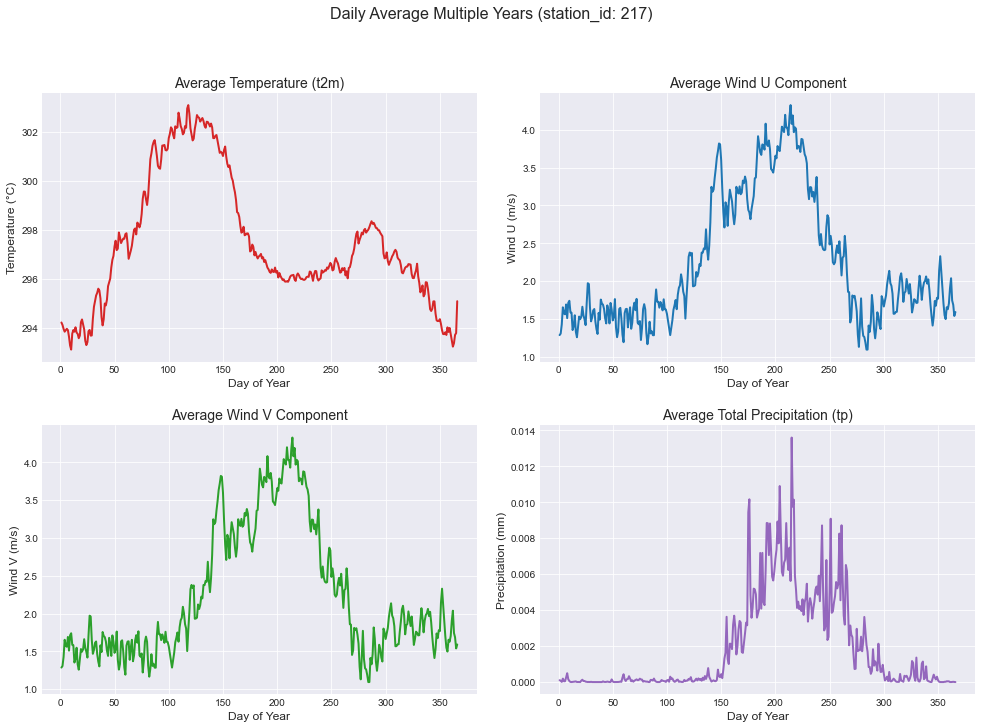

In [75]:
plot_daily_average_in_years('../../data/station_climate_by_year/217')

Finished reading data...info below:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93741 entries, 2017-02-19 22:00:00 to 2019-12-30 02:00:00
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       93741 non-null  int64  
 1   Location name    93741 non-null  object 
 2   District         93741 non-null  object 
 3   State            93741 non-null  object 
 4   Category         93741 non-null  object 
 5   Connection Type  93741 non-null  object 
 6   Lat              93741 non-null  float64
 7   Lon              93741 non-null  float64
 8   t2m              93741 non-null  float64
 9   u10              93741 non-null  float64
 10  v10              93741 non-null  float64
 11  tp               93741 non-null  float64
 12  date             93741 non-null  object 
 13  time             93741 non-null  object 
dtypes: float64(6), int64(1), object(7)
memory usage: 10.7+ MB
None
DatetimeIndex(['

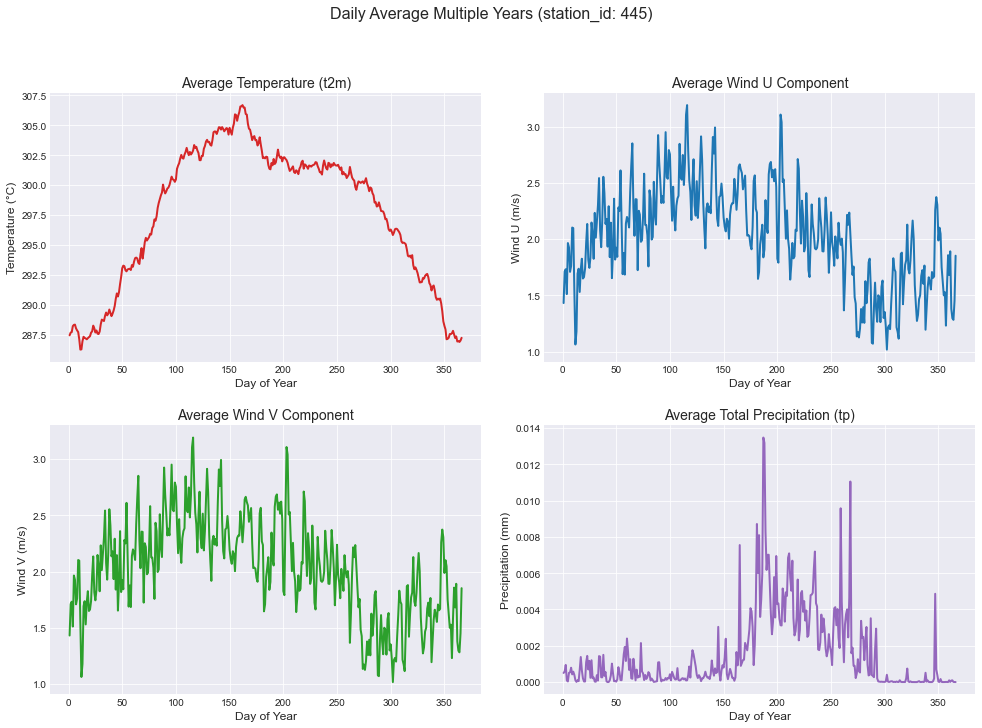

In [76]:
plot_daily_average_in_years('../../data/station_climate_by_year/445')

In [ ]:
plot_daily_average_in_years('../../data/station_climate_by_year/486')

In [80]:
# make box plot for each variable in each month

def plot_monthly_box_plot(input_dir):
	df = read_climate_data(input_dir)
	folder_name = input_dir.split('/')[-1]

	df['year'] = df.index.year
	df['month'] = df.index.month
	df['season'] = df['month'].apply(get_season)

	plt.style.use('seaborn-darkgrid')  

	fig, axes = plt.subplots(2, 2, figsize=(14, 10))
	fig.suptitle(
		'Box Plot of ERA5-Land Data Across Multiple Years', fontsize=16, y=1.02)

	season_colors = {'Winter': 'tab:blue', 'Summer': 'tab:orange',
					 'Monsoon': 'tab:green', 'Post-monsoon': 'tab:red'}

	def plot_box_plot(ax, variable, title, ylabel):
		df.boxplot(column=variable, by='month', ax=ax)
		ax.set_title(title, fontsize=14)
		ax.set_ylabel(ylabel, fontsize=12)
		ax.grid(True)

	plot_box_plot(axes[0, 0], 't2m', 'Temperature (t2m)', 'Temperature (°C)')
	plot_box_plot(axes[0, 1], 'u10', 'Wind U Component', 'Wind U (m/s)')
	plot_box_plot(axes[1, 0], 'v10', 'Wind V Component', 'Wind V (m/s)')
	plot_box_plot(
		axes[1, 1], 'tp', 'Total Precipitation (tp)', 'Precipitation (mm)')

	for ax in axes.flat:
		ax.set_xlabel('Month', fontsize=12)

	plt.tight_layout(pad=2)

	# print outliers

	fig.suptitle(
	f'Box Plot of ERA5-Land Data Across Multiple Years (station_id: {folder_name})', fontsize=16, y=1.02)

	# use f string to save file

	plt.savefig(f'../../data/box_plot_multiple_years_{folder_name}.png', dpi=600)

	print('Finished plotting box plot...')
	print(f'../../data/box_plot_multiple_years_{folder_name}.png')

Finished reading data...info below:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 98517 entries, 2023-07-06 04:00:00 to 2013-08-03 16:00:00
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       98517 non-null  int64  
 1   Location name    98517 non-null  object 
 2   District         98517 non-null  object 
 3   State            98517 non-null  object 
 4   Category         98517 non-null  object 
 5   Connection Type  98517 non-null  object 
 6   Lat              98517 non-null  float64
 7   Lon              98517 non-null  float64
 8   t2m              98517 non-null  float64
 9   u10              98517 non-null  float64
 10  v10              98517 non-null  float64
 11  tp               98517 non-null  float64
 12  date             98517 non-null  object 
 13  time             98517 non-null  object 
dtypes: float64(6), int64(1), object(7)
memory usage: 11.3+ MB
None
DatetimeIndex(['

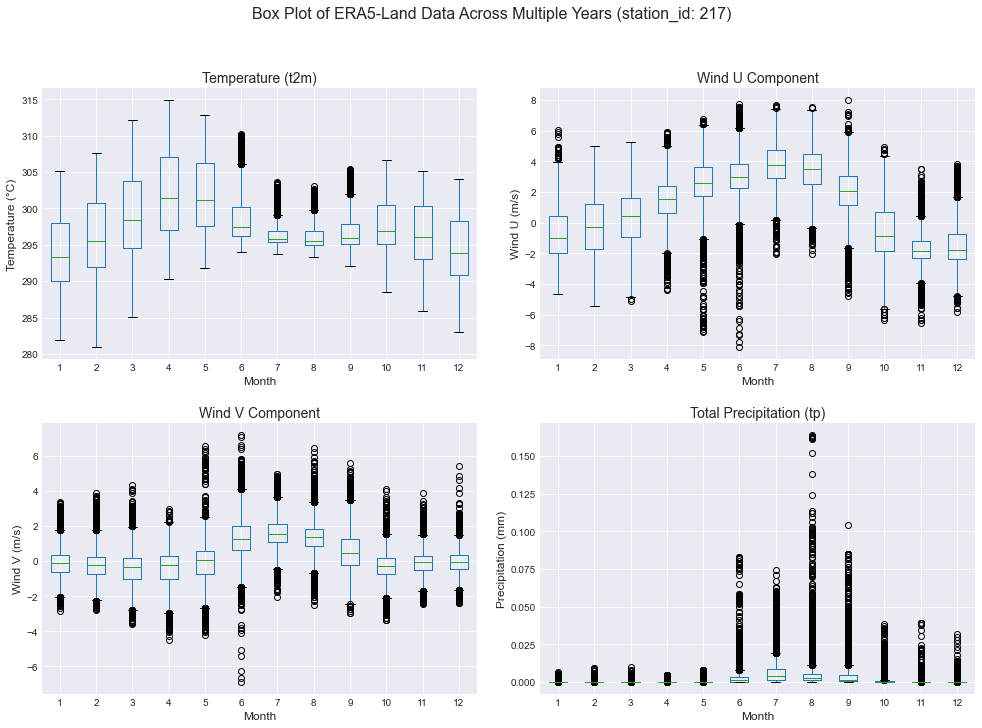

In [81]:
plot_monthly_box_plot('../../data/station_climate_by_year/217')

Finished reading data...info below:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93741 entries, 2017-02-19 22:00:00 to 2019-12-30 02:00:00
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       93741 non-null  int64  
 1   Location name    93741 non-null  object 
 2   District         93741 non-null  object 
 3   State            93741 non-null  object 
 4   Category         93741 non-null  object 
 5   Connection Type  93741 non-null  object 
 6   Lat              93741 non-null  float64
 7   Lon              93741 non-null  float64
 8   t2m              93741 non-null  float64
 9   u10              93741 non-null  float64
 10  v10              93741 non-null  float64
 11  tp               93741 non-null  float64
 12  date             93741 non-null  object 
 13  time             93741 non-null  object 
dtypes: float64(6), int64(1), object(7)
memory usage: 10.7+ MB
None
DatetimeIndex(['

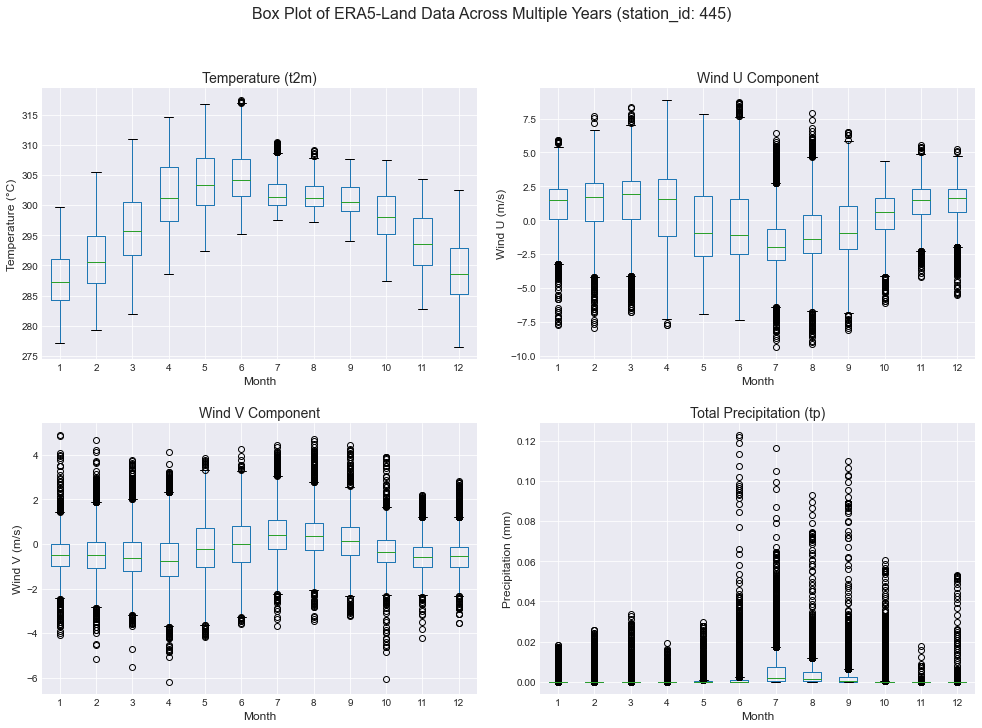

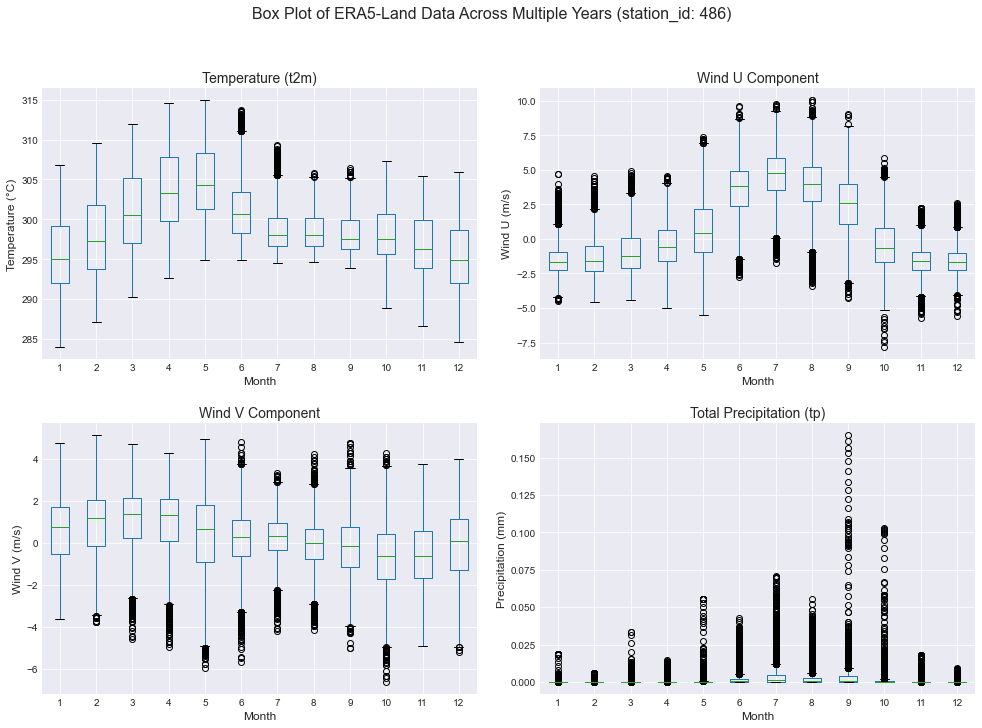

In [82]:
plot_monthly_box_plot('../../data/station_climate_by_year/445')

plot_monthly_box_plot('../../data/station_climate_by_year/486')

In [83]:
# plot the distribution of each variable in each day, using month as a unit, and use violin plot

def plot_monthly_violin_plot(input_dir):
	
	df = read_climate_data(input_dir)
	folder_name = input_dir.split('/')[-1]

	df['year'] = df.index.year
	df['month'] = df.index.month
	df['season'] = df['month'].apply(get_season)

	plt.style.use('seaborn-darkgrid')  

	fig, axes = plt.subplots(2, 2, figsize=(14, 10))
	fig.suptitle(
		'Violin Plot of ERA5-Land Data Across Multiple Years', fontsize=16, y=1.02)

	season_colors = {'Winter': 'tab:blue', 'Summer': 'tab:orange',
					 'Monsoon': 'tab:green', 'Post-monsoon': 'tab:red'}

	def plot_violin_plot(ax, variable, title, ylabel):
		sns.violinplot(x='month', y=variable, data=df, ax=ax)
		ax.set_title(title, fontsize=14)
		ax.set_ylabel(ylabel, fontsize=12)
		ax.grid(True)

	plot_violin_plot(axes[0, 0], 't2m', 'Temperature (t2m)', 'Temperature (°C)')
	plot_violin_plot(axes[0, 1], 'u10', 'Wind U Component', 'Wind U (m/s)')
	plot_violin_plot(axes[1, 0], 'v10', 'Wind V Component', 'Wind V (m/s)')
	plot_violin_plot(
		axes[1, 1], 'tp', 'Total Precipitation (tp)', 'Precipitation (mm)')

	for ax in axes.flat:
		ax.set_xlabel('Month', fontsize=12)

	plt.tight_layout(pad=2)

	# print outliers

	fig.suptitle(
	f'Violin Plot of ERA5-Land Data Across Multiple Years (station_id: {folder_name})', fontsize=16, y=1.02)

	# use f string to save file

	plt.savefig(f'../../data/violin_plot_multiple_years_{folder_name}.png', dpi=600)

	print('Finished plotting violin plot...')
	print(f'../../data/violin_plot_multiple_years_{folder_name}.png')

Finished reading data...info below:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 98517 entries, 2023-07-06 04:00:00 to 2013-08-03 16:00:00
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       98517 non-null  int64  
 1   Location name    98517 non-null  object 
 2   District         98517 non-null  object 
 3   State            98517 non-null  object 
 4   Category         98517 non-null  object 
 5   Connection Type  98517 non-null  object 
 6   Lat              98517 non-null  float64
 7   Lon              98517 non-null  float64
 8   t2m              98517 non-null  float64
 9   u10              98517 non-null  float64
 10  v10              98517 non-null  float64
 11  tp               98517 non-null  float64
 12  date             98517 non-null  object 
 13  time             98517 non-null  object 
dtypes: float64(6), int64(1), object(7)
memory usage: 11.3+ MB
None
DatetimeIndex(['

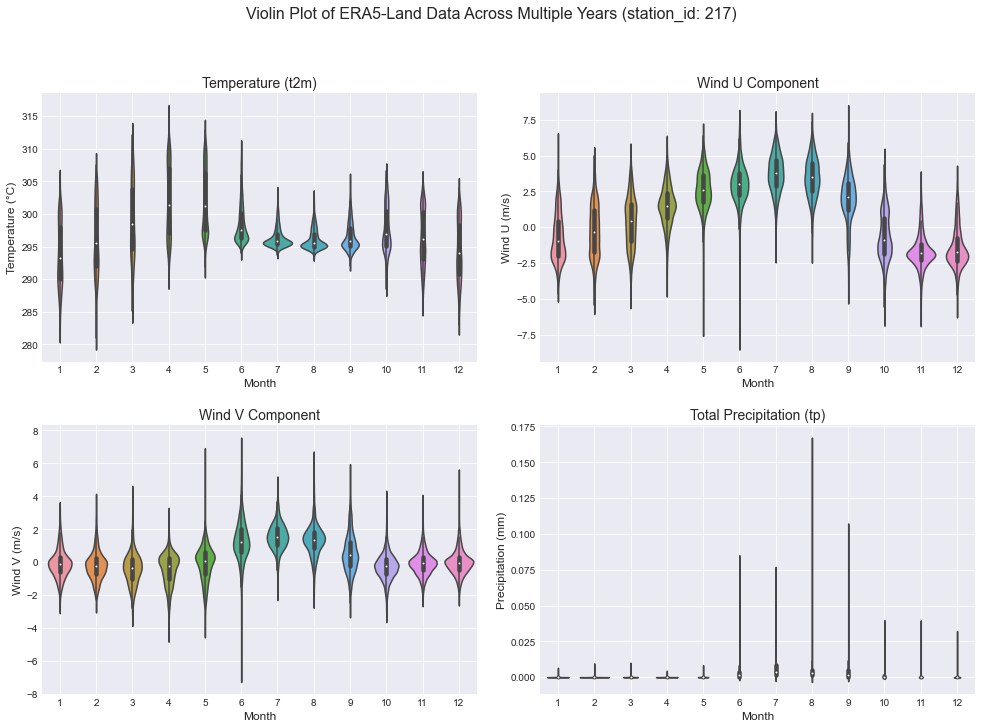

In [84]:
plot_monthly_violin_plot('../../data/station_climate_by_year/217')

Finished reading data...info below:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93741 entries, 2017-02-19 22:00:00 to 2019-12-30 02:00:00
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       93741 non-null  int64  
 1   Location name    93741 non-null  object 
 2   District         93741 non-null  object 
 3   State            93741 non-null  object 
 4   Category         93741 non-null  object 
 5   Connection Type  93741 non-null  object 
 6   Lat              93741 non-null  float64
 7   Lon              93741 non-null  float64
 8   t2m              93741 non-null  float64
 9   u10              93741 non-null  float64
 10  v10              93741 non-null  float64
 11  tp               93741 non-null  float64
 12  date             93741 non-null  object 
 13  time             93741 non-null  object 
dtypes: float64(6), int64(1), object(7)
memory usage: 10.7+ MB
None
DatetimeIndex(['

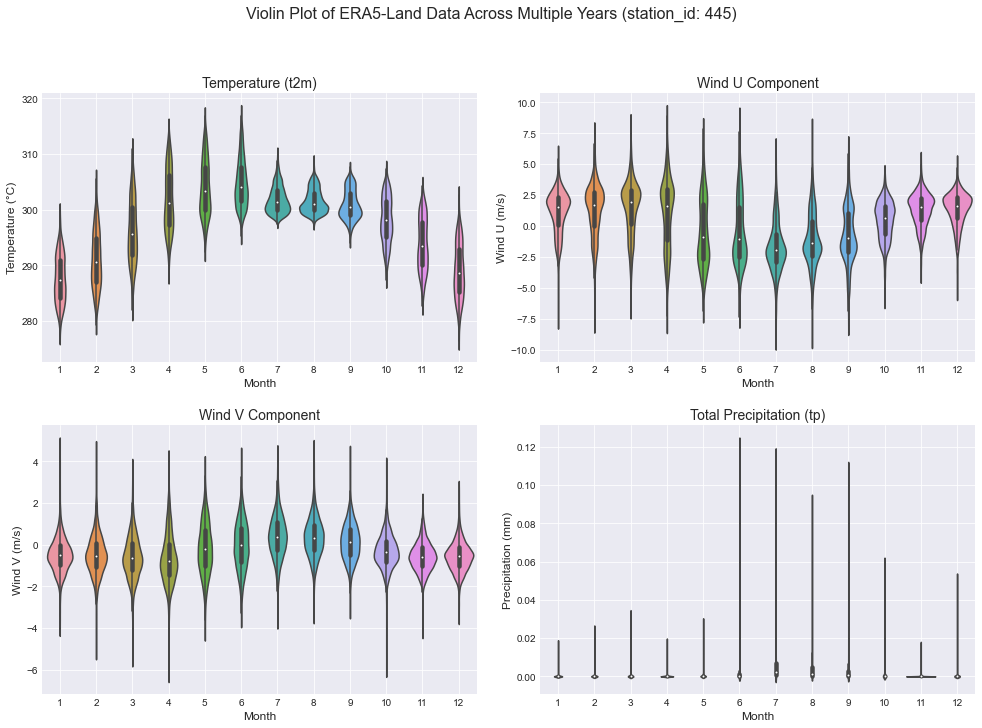

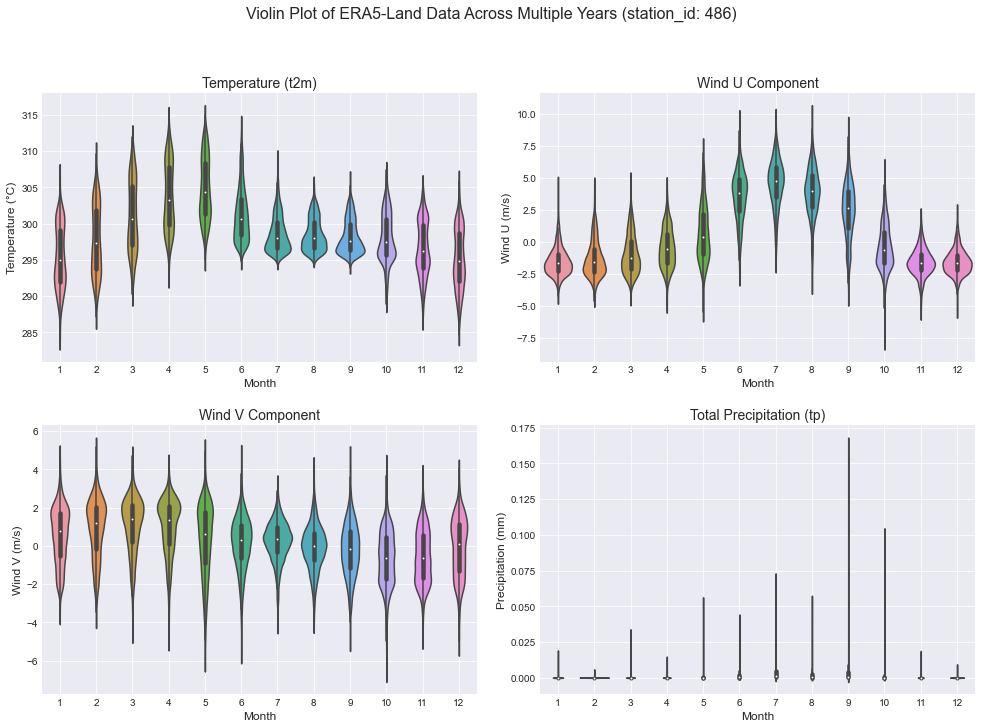

In [85]:
plot_monthly_violin_plot('../../data/station_climate_by_year/445')

plot_monthly_violin_plot('../../data/station_climate_by_year/486')

In [104]:

def plot_monthly_line_chart(input_dir, variable):
	df = read_climate_data(input_dir)
	folder_name = input_dir.split('/')[-1]

	df['year'] = df.index.year
	df['month'] = df.index.month
	df['season'] = df['month'].apply(get_season)

	if variable == 'u10' or variable == 'v10':
		df['variable'] = np.abs(df[variable])
	elif variable == 'wind_speed':
		df['variable'] = np.sqrt(df['u10']**2 + df['v10']**2)
	else:
		df['variable'] = df[variable]

	plt.style.use('seaborn-darkgrid')  

	fig, axes = plt.subplots(3, 4, figsize=(20, 12))
	fig.suptitle(
		f'Monthly Line Chart of {variable} Across Multiple Years', fontsize=16, y=1.02)

	season_colors = {'Winter': 'tab:blue', 'Summer': 'tab:orange',
					 'Monsoon': 'tab:green', 'Post-monsoon': 'tab:red'}

	def plot_line_chart(ax, month, title, ylabel):
		# extract day of month
		# calculate the mean value of the variable in that day of month
		df_month = df[df['month'] == month]
		df_month_mean = df_month.groupby(df_month.index.day).mean

		plot_index = df_month.index.day
		
		ax.plot(plot_index, df_month_mean['variable'], color='tab:blue')
		ax.set_title(title, fontsize=14)
		ax.set_ylabel(ylabel, fontsize=12)
		ax.grid(True)

	for i, ax in enumerate(axes.flat):
		plot_line_chart(ax, i + 1, f'{variable} in {i + 1} Month', f'{variable} Value')

	for ax in axes.flat:
		ax.set_xlabel('Day of Month', fontsize=12)

	plt.tight_layout(pad=2)

	# print outliers

	fig.suptitle(
	f'Monthly Line Chart of {variable} Across Multiple Years (station_id: {folder_name})', fontsize=16, y=1.02)

	# use f string to save file

	plt.savefig(f'../../data/monthly_line_chart_{variable}_{folder_name}.png', dpi=600)

	print('Finished plotting monthly line chart...')
	print(f'../../data/monthly_line_chart_{variable}_{folder_name}.png')

In [113]:


def plot_monthly_line_chart(input_dir, variable):
    df = read_climate_data(input_dir)  # Assuming read_climate_data is defined
    folder_name = input_dir.split('/')[-1]


    df['year'] = df.index.year
    df['month'] = df.index.month
    df['season'] = df['month'].apply(get_season)

    if variable == 'u10' or variable == 'v10':
        df['variable'] = np.abs(df[variable])
    elif variable == 'wind_speed':
        df['variable'] = np.sqrt(df['u10']**2 + df['v10']**2)
    else:
        df['variable'] = df[variable]

    plt.style.use('seaborn-darkgrid')

    fig, axes = plt.subplots(3, 4, figsize=(20, 12))
    fig.suptitle(
        f'Monthly Line Chart of {variable} Across Multiple Years in station_id: {folder_name}', fontsize=16, y=1.02)

    def plot_line_chart(ax, month, title, ylabel):
        # Filter data for the given month
        df_month = df[df['month'] == month]

        # Calculate the mean value for each day of the month
        df_month_mean = df_month.groupby(df_month.index.day).mean()

        plot_index = df_month_mean.index  # Day of the month

        ax.plot(plot_index, df_month_mean['variable'], color='tab:blue')
        ax.set_title(title, fontsize=14)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.grid(True)

    # Loop through each month (January to December)
    for i, ax in enumerate(axes.flat):
        plot_line_chart(
            ax, i + 1, f'{variable} in {i + 1} Month', f'{variable} Value')

    for ax in axes.flat:
        ax.set_xlabel('Day of Month', fontsize=12)

    plt.tight_layout(pad=2)

    # Save the figure
    plt.savefig(
        f'../../data/monthly_line_chart_{variable}_{folder_name}.png', dpi=600)

    print('Finished plotting monthly line chart...')
    print(f'../../data/monthly_line_chart_{variable}_{folder_name}.png')

In [121]:

def plot_monthly_line_chart(input_dir, variable):
    df = read_climate_data(input_dir)  # Assuming read_climate_data is defined
    folder_name = input_dir.split('/')[-1]



    df['year'] = df.index.year
    df['month'] = df.index.month
    df['season'] = df['month'].apply(get_season)

    if variable == 'u10' or variable == 'v10':
        df['variable'] = np.abs(df[variable])
    elif variable == 'wind_speed':
        df['variable'] = np.sqrt(df['u10']**2 + df['v10']**2)
    else:
        df['variable'] = df[variable]

    plt.style.use('seaborn-darkgrid')

    fig, axes = plt.subplots(3, 4, figsize=(20, 12))
    fig.suptitle(
        f'Monthly Line Chart of {variable} Across Multiple Years', fontsize=16, y=1.02)

    def plot_line_chart(ax, month, title, ylabel):
        # Filter data for the given month
        df_month = df[df['month'] == month]

        # Calculate the mean value for each day of the month
        df_month_mean = df_month.groupby(df_month.index.day).mean()

        plot_index = df_month_mean.index  # Day of the month

        ax.plot(plot_index, df_month_mean['variable'], color='tab:blue')
        ax.set_title(title, fontsize=14)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.grid(True)

    # Loop through each month (January to December)
    for i, ax in enumerate(axes.flat):
        # Get month name (January, February, etc.)
        month_name = calendar.month_name[i + 1]
        plot_line_chart(
            ax, i + 1, f'{month_name}', f'{variable} Value')

    for ax in axes.flat:
        ax.set_xlabel('Day of Month', fontsize=12)

    plt.tight_layout(pad=2)

    # Save the figure
    plt.savefig(
        f'../../data/monthly_line_chart_{variable}_{folder_name}.png', dpi=600)

    print('Finished plotting monthly line chart...')
    print(f'../../data/monthly_line_chart_{variable}_{folder_name}.png')

Finished reading data...info below:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 98517 entries, 2023-07-06 04:00:00 to 2013-08-03 16:00:00
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       98517 non-null  int64  
 1   Location name    98517 non-null  object 
 2   District         98517 non-null  object 
 3   State            98517 non-null  object 
 4   Category         98517 non-null  object 
 5   Connection Type  98517 non-null  object 
 6   Lat              98517 non-null  float64
 7   Lon              98517 non-null  float64
 8   t2m              98517 non-null  float64
 9   u10              98517 non-null  float64
 10  v10              98517 non-null  float64
 11  tp               98517 non-null  float64
 12  date             98517 non-null  object 
 13  time             98517 non-null  object 
dtypes: float64(6), int64(1), object(7)
memory usage: 11.3+ MB
None
DatetimeIndex(['

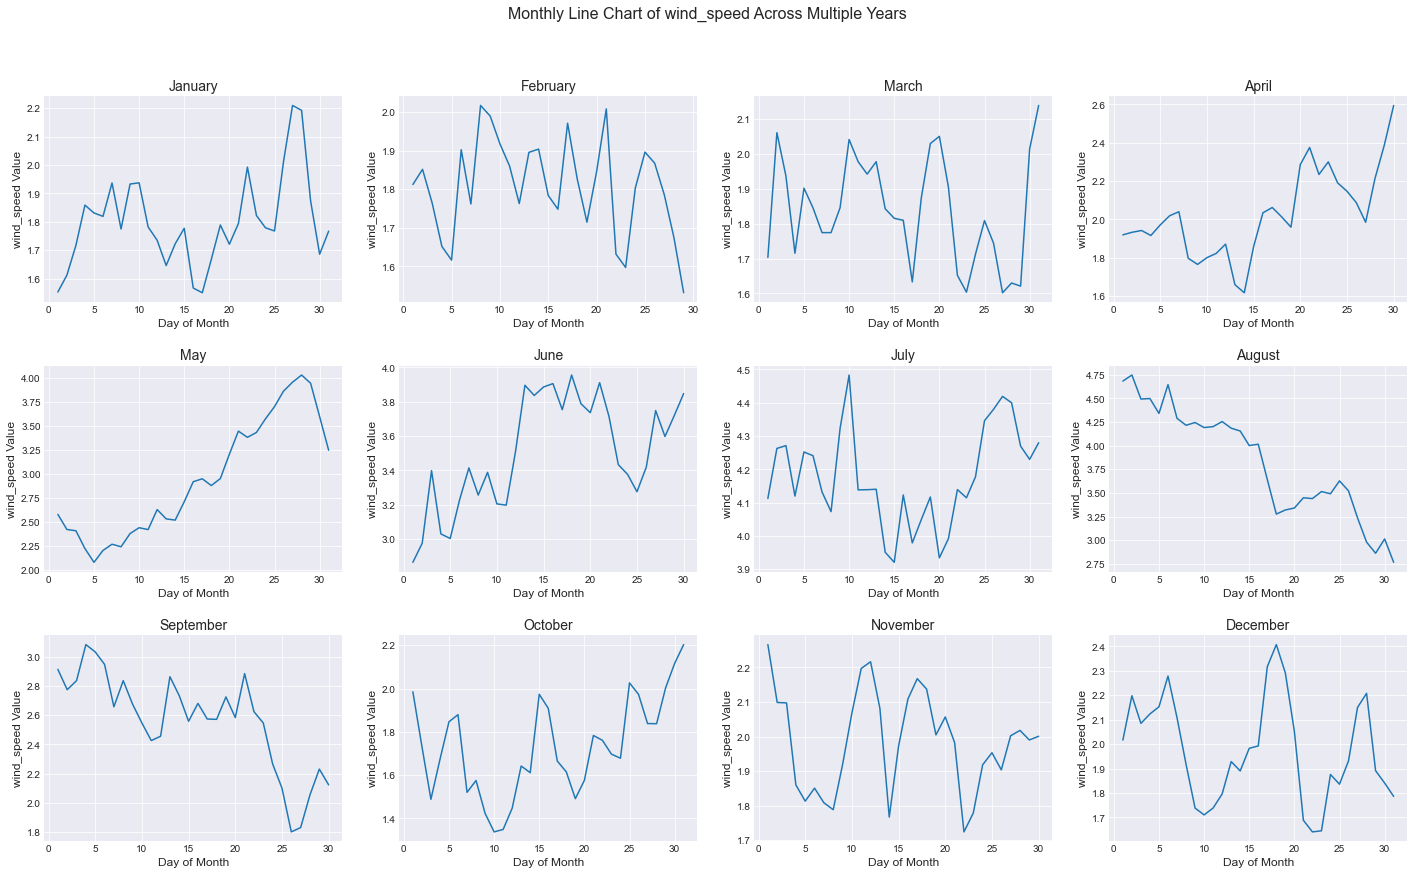

In [122]:
plot_monthly_line_chart('../../data/station_climate_by_year/217',variable='wind_speed')

Finished reading data...info below:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 98517 entries, 2023-07-06 04:00:00 to 2013-08-03 16:00:00
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       98517 non-null  int64  
 1   Location name    98517 non-null  object 
 2   District         98517 non-null  object 
 3   State            98517 non-null  object 
 4   Category         98517 non-null  object 
 5   Connection Type  98517 non-null  object 
 6   Lat              98517 non-null  float64
 7   Lon              98517 non-null  float64
 8   t2m              98517 non-null  float64
 9   u10              98517 non-null  float64
 10  v10              98517 non-null  float64
 11  tp               98517 non-null  float64
 12  date             98517 non-null  object 
 13  time             98517 non-null  object 
dtypes: float64(6), int64(1), object(7)
memory usage: 11.3+ MB
None
DatetimeIndex(['

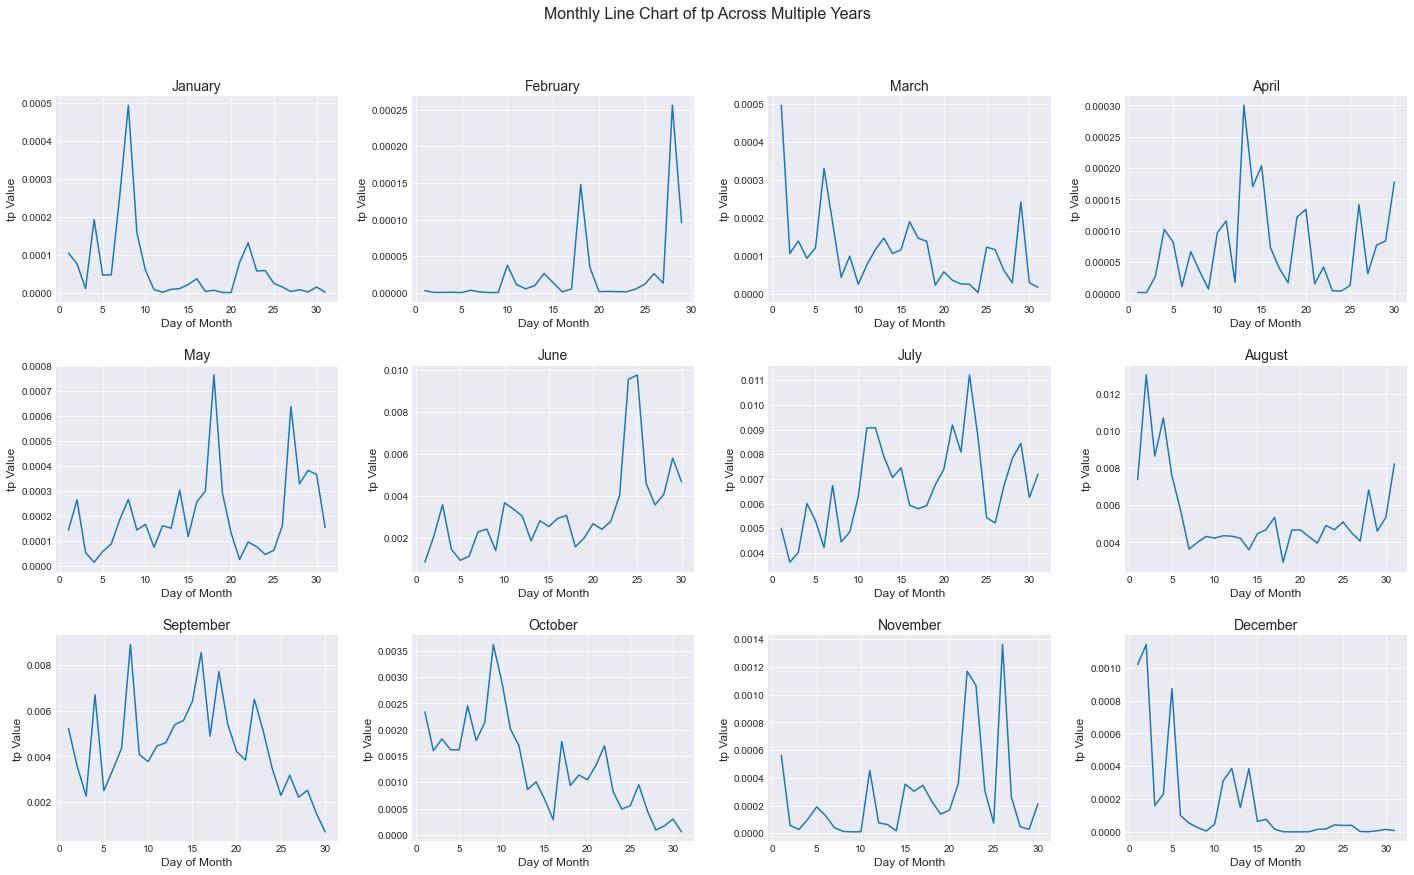

In [123]:
plot_monthly_line_chart('../../data/station_climate_by_year/217', variable='tp')

Finished reading data...info below:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93741 entries, 2017-02-19 22:00:00 to 2019-12-30 02:00:00
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       93741 non-null  int64  
 1   Location name    93741 non-null  object 
 2   District         93741 non-null  object 
 3   State            93741 non-null  object 
 4   Category         93741 non-null  object 
 5   Connection Type  93741 non-null  object 
 6   Lat              93741 non-null  float64
 7   Lon              93741 non-null  float64
 8   t2m              93741 non-null  float64
 9   u10              93741 non-null  float64
 10  v10              93741 non-null  float64
 11  tp               93741 non-null  float64
 12  date             93741 non-null  object 
 13  time             93741 non-null  object 
dtypes: float64(6), int64(1), object(7)
memory usage: 10.7+ MB
None
DatetimeIndex(['

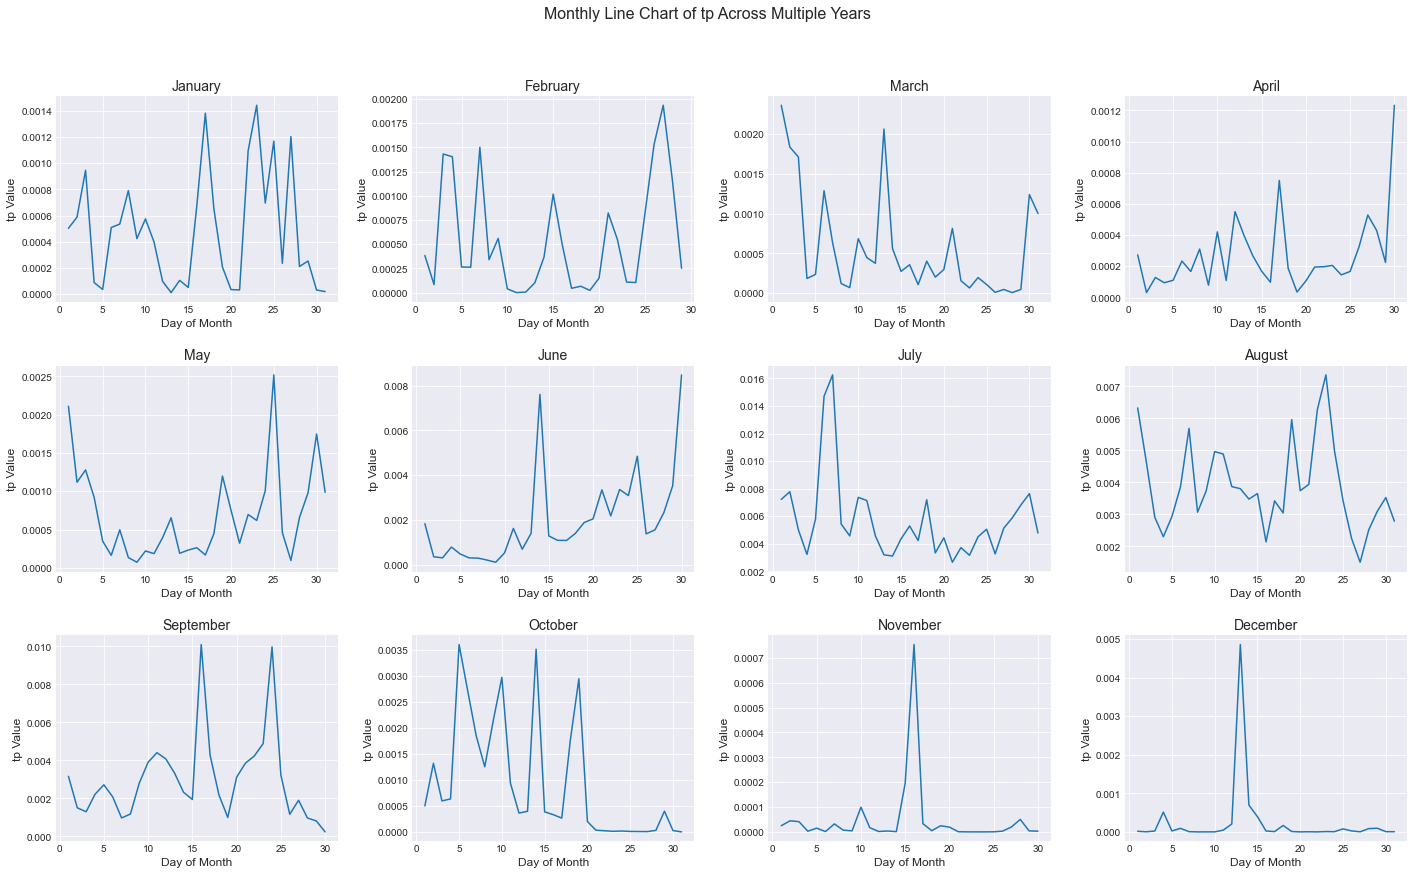

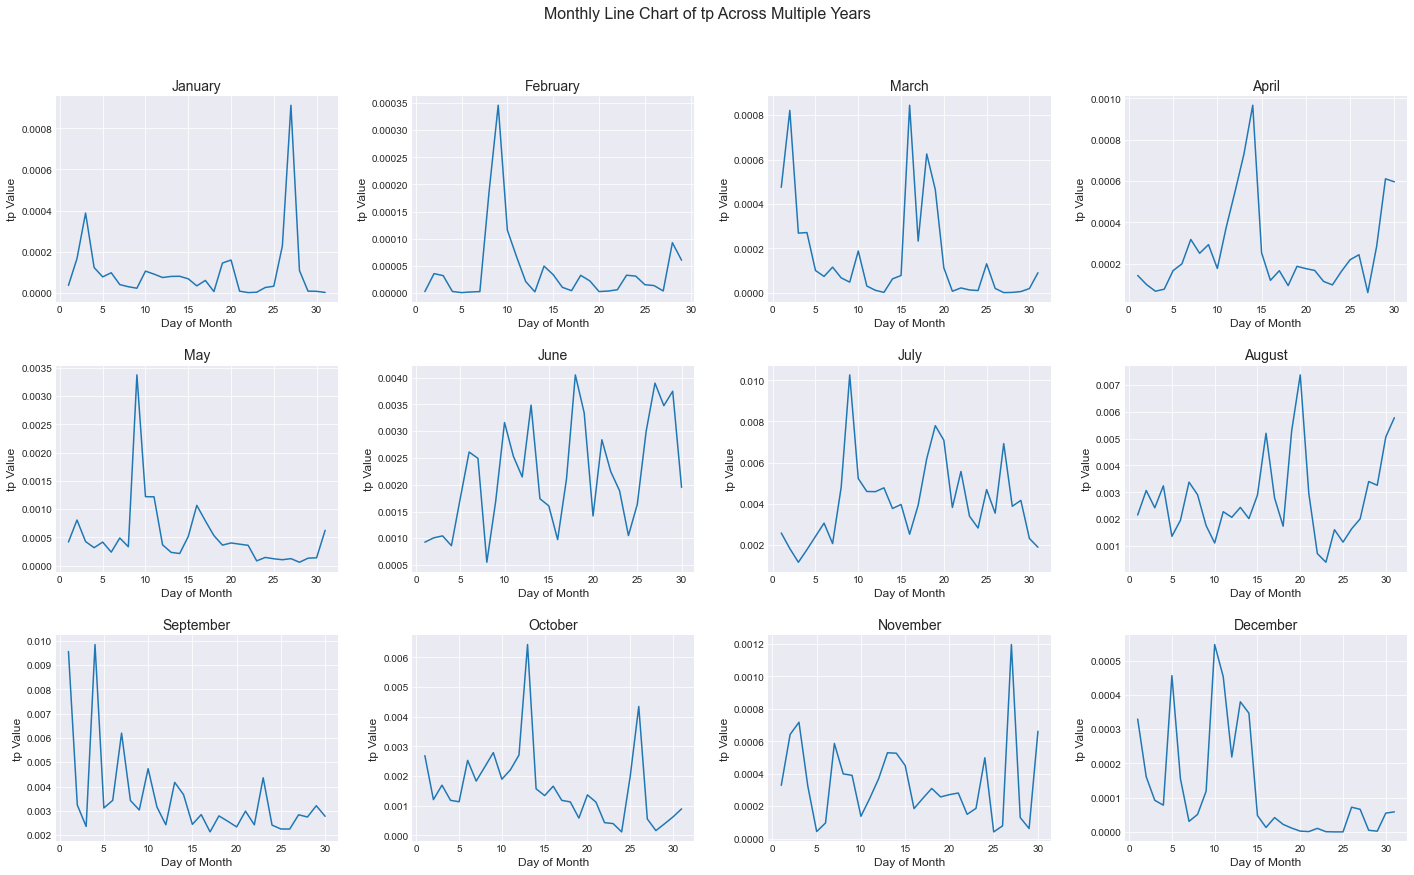

In [125]:
plot_monthly_line_chart('../../data/station_climate_by_year/445', variable='tp')
plot_monthly_line_chart('../../data/station_climate_by_year/486', variable='tp')
